# Batch Gradient Descent for softmax regression

Implement Batch Gradient Descent with early stopping for softmax regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from copy import deepcopy

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

np.random.seed(12345)

In [2]:
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

#### General approach

In [3]:
def one_hot(data, classes):
    return np.eye(classes)[data]

def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

In [4]:
def get_probabilities(X, Thetas):
    logits = X @ Thetas
    y_proba = softmax(logits)
    return y_proba

def get_parameter_matrix(X, y_oh, n_iters=5000, eta=0.1, l2_reg_lambda=0., n_early_stop=-1,
                         EPS=1e-7, verbose=False, log_freq=1000):
    m = X.shape[0]
    
    regularize     = (l2_reg_lambda > 0.)
    early_stopping = (n_early_stop >= 0)
    calculate_loss = (verbose or early_stopping)
    
    # Parameter matrix (Thetas) is effectively a linear transformation,
    # hence we define its dimensions below.
    transform_inputs  = X.shape[1]     # number of features plus the bias term
    transform_outputs = y_oh.shape[1]  # number of classes
    
    # Random initialization
    Thetas = np.random.randn(transform_inputs, transform_outputs)
    
    # Early stopping
    lowest_loss = np.infty
    best_Thetas = deepcopy(Thetas)
    faults_left = n_early_stop  # Counter of the failures left before stopping early

    for i in range(n_iters):
        y_proba = get_probabilities(X, Thetas)
        error = y_proba - y_oh
        
        # Batch Gradient Descent
        gradients = 1/m * X.T @ error
        if regularize:
            gradients += np.r_[np.zeros([1, transform_outputs]), l2_reg_lambda * Thetas[1:]]
        
        Thetas = Thetas - eta * gradients
        
        if calculate_loss:
            # Cross entropy loss
            # (!) np.log(0) is an ill-formed expression, returning possibly -inf or even nan.
            #     To prevent such situation tiny epsilon is added to the logarithms argument.
            cross_entropy_loss = -np.mean(np.sum(y_oh * np.log(y_proba + 1e-7), axis=1))

            # Regularization loss (if needed anywhere)
            # l2_regularization_loss = 0.5 * np.sum(np.square(Thetas[1:])) if regularize else 0.

            # Total loss (cross entropy loss + regularization loss)
            # loss = cross_entropy_loss + l2_reg_lambda * l2_regularization_loss
            loss = cross_entropy_loss
            
            # Logging
            if verbose and (i+1) % log_freq == 0:
                print("{:>5} iterations done. Current loss: {}".format(i+1, loss))
            
            # Early stopping
            if early_stopping:
                if loss + EPS < lowest_loss:
                    lowest_loss = loss
                    best_Thetas = deepcopy(Thetas)
                    faults_left = n_early_stop
                else:
                    if faults_left <= 0:
                        if verbose: print("Early stopping after {} iterations.".format(i+1))
                        break
                    else:
                        faults_left -= 1
    
    if verbose:
        print("Done. Achieved loss: {}".format(loss))
    
    return best_Thetas

In [5]:
def get_predictions(X, Thetas):
    y_proba = get_probabilities(X, Thetas)
    return np.argmax(y_proba, axis=1)

In [6]:
X = iris["data"][:, (2, 3)]
X_bias = np.c_[np.ones([X.shape[0], 1]), X]

y = iris["target"]
X_train, X_valid, y_train, y_valid = train_test_split(X_bias, y, train_size=0.8, random_state=1)

classes = len(np.unique(y))
y_train_oh = one_hot(y_train, classes)
y_valid_oh = one_hot(y_valid, classes)

In [7]:
Thetas = get_parameter_matrix(X_train, y_train_oh, 10000,
                              eta=0.1, n_early_stop=0, l2_reg_lambda=0.15, verbose=True)

 1000 iterations done. Current loss: 0.43969093460384845
 2000 iterations done. Current loss: 0.4181194627083617
 3000 iterations done. Current loss: 0.41267391617833965
 4000 iterations done. Current loss: 0.4110834218685937
 5000 iterations done. Current loss: 0.41060293781126905
Early stopping after 5775 iterations.
Done. Achieved loss: 0.4104760931993877


In [8]:
Thetas

array([[ 3.46687784,  0.16604672, -3.87812759],
       [-0.91613869,  0.11463819,  0.8015005 ],
       [-0.36941755, -0.10239965,  0.47181721]])

In [9]:
get_probabilities(X_valid[:10], Thetas)

array([[0.87725088, 0.11748348, 0.00526563],
       [0.42181504, 0.45933792, 0.11884704],
       [0.0998894 , 0.49893499, 0.40117562],
       [0.85833928, 0.13442218, 0.00723854],
       [0.0039435 , 0.18167965, 0.81437685],
       [0.06198172, 0.4449173 , 0.49310098],
       [0.02349279, 0.30703619, 0.66947103],
       [0.76085483, 0.22116183, 0.01798334],
       [0.82359071, 0.16658225, 0.00982704],
       [0.00951239, 0.23074975, 0.75973786]])

In [10]:
predictions = get_predictions(X_valid, Thetas)
predictions

array([0, 1, 1, 0, 2, 2, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       2, 0, 2, 1, 0, 0, 1, 2], dtype=int64)

In [11]:
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 93.33%


Not bad. Let's turn it into sklearn transformer to integrate this with scikit-learn framework.

#### Scikit-learn transformer 

In [12]:
class BatchGradientDescent(BaseEstimator, TransformerMixin):
    def __init__(self, n_iters=5000, eta=0.1, l2_lambda=0., n_early_stop=-1,
                 EPS=1e-7, verbose=False, log_freq=1000, add_bias=True):
        self.n_iters = n_iters
        self.eta = eta
        self.l2_lambda = l2_lambda
        self.n_early_stop = n_early_stop
        self.EPS = EPS
        self.verbose = verbose
        self.log_freq = log_freq
        self.add_bias = add_bias
        self.Thetas = None
    
    @staticmethod
    def __one_hot(data, classes):
        return np.eye(classes)[data]
    
    @staticmethod
    def __softmax(logits):
        exps = np.exp(logits)
        exp_sums = np.sum(exps, axis=1, keepdims=True)
        return exps / exp_sums
    
    @staticmethod
    def get_probabilities(X, Thetas):
        logits = X @ Thetas
        y_proba = BatchGradientDescent.__softmax(logits)
        return y_proba
    
    def __bgd(self, X, y):
        m = X.shape[0]
        y_oh = BatchGradientDescent.__one_hot(y, len(np.unique(y)))
        
        regularize     = (self.l2_lambda > 0.)
        early_stopping = (self.n_early_stop >= 0)
        calculate_loss = (self.verbose or early_stopping)
        
        transform_inputs  = X.shape[1]     # number of features plus the bias term
        transform_outputs = y_oh.shape[1]  # number of classes
        
        Thetas = np.random.randn(transform_inputs, transform_outputs)
        
        lowest_loss = np.infty
        best_Thetas = deepcopy(Thetas)
        faults_left = self.n_early_stop

        for i in range(self.n_iters):
            y_proba = self.get_probabilities(X, Thetas)
            error = y_proba - y_oh

            gradients = 1/m * X.T @ error
            if regularize:
                gradients += np.r_[np.zeros([1, transform_outputs]), self.l2_lambda * Thetas[1:]]

            Thetas = Thetas - self.eta * gradients
            
            if not early_stopping:
                best_Thetas = deepcopy(Thetas)
            
            if calculate_loss:
                cross_entropy_loss = -np.mean(np.sum(y_oh * np.log(y_proba + 1e-7), axis=1))
                loss = cross_entropy_loss
                
                if self.verbose and (i+1) % self.log_freq == 0:
                    print("{:>5} iterations done. Current loss: {}".format(i+1, loss))
                
                if early_stopping:
                    if loss + self.EPS < lowest_loss:
                        lowest_loss = loss
                        best_Thetas = deepcopy(Thetas)
                        faults_left = self.n_early_stop
                    else:
                        if faults_left <= 0:
                            if self.verbose: print("Early stopping after {} iterations.".format(i+1))
                            break
                        else:
                            faults_left -= 1

        if self.verbose:
            print("Done. Achieved loss: {}".format(loss))

        self.Thetas = deepcopy(best_Thetas)
    
    def fit(self, X, y=None):
        if self.add_bias:
            self.__bgd(np.c_[np.ones([X.shape[0], 1]), np.array(X)], y)
        else:
            self.__bgd(np.array(X), y)
    
    def transform(self, X):
        if self.Thetas is None:
            print("Model hasn't been fitted yet.")
            return None
            
        if self.add_bias:
            y_proba = BatchGradientDescent.get_probabilities(
                np.c_[np.ones([X.shape[0], 1]), np.array(X)], self.Thetas
            )
        else:
            y_proba = BatchGradientDescent.get_probabilities(
                np.array(X), self.Thetas
            )
        
        if type(X) == pd.core.frame.DataFrame:
            return pd.Series(data=np.argmax(y_proba, axis=1), index=X.index)
        else:
            return np.argmax(y_proba, axis=1)
    
    def predict(self, X):
        return self.transform(X)

In [13]:
bgd = BatchGradientDescent(verbose=True, add_bias=False)

In [14]:
bgd.fit(X_train, y_train)

 1000 iterations done. Current loss: 0.2851058341198672
 2000 iterations done. Current loss: 0.2229733952805762
 3000 iterations done. Current loss: 0.19110901885282125
 4000 iterations done. Current loss: 0.17102071897945345
 5000 iterations done. Current loss: 0.15700385002058848
Done. Achieved loss: 0.15700385002058848


In [15]:
predictions = bgd.transform(X_valid)
predictions

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       2, 0, 2, 1, 0, 0, 1, 2], dtype=int64)

In [16]:
y_valid

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 2, 1, 0, 0, 1, 2])

In [17]:
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 96.67%


#### Proper data preparation

In [18]:
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [19]:
data = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
target = pd.DataFrame(data=iris['target'], columns=['species'])

target_names = target['species'].map(lambda x: iris['target_names'][x])
target_names.name = 'species_name'

full = pd.concat([data, target, target_names], axis=1)

full

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [20]:
full.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [21]:
iris['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [22]:
full['species_name'].value_counts().sort_index()

setosa        50
versicolor    50
virginica     50
Name: species_name, dtype: int64

In [23]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_idx, valid_idx in split.split(full, full['species']):
    train_full = full.iloc[train_idx].copy()
    valid_full = full.iloc[valid_idx].copy()

In [24]:
valid_full[:10]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
36,5.5,3.5,1.3,0.2,0,setosa
55,5.7,2.8,4.5,1.3,1,versicolor
44,5.1,3.8,1.9,0.4,0,setosa
134,6.1,2.6,5.6,1.4,2,virginica
39,5.1,3.4,1.5,0.2,0,setosa
90,5.5,2.6,4.4,1.2,1,versicolor
147,6.5,3.0,5.2,2.0,2,virginica
47,4.6,3.2,1.4,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
81,5.5,2.4,3.7,1.0,1,versicolor


In [25]:
X_train = train_full.drop(['species', 'species_name'], axis=1)
y_train = train_full['species']

X_valid = valid_full.drop(['species', 'species_name'], axis=1)
y_valid = valid_full['species']

X_full = full.drop(['species', 'species_name'], axis=1)
y_full = full['species']

In [26]:
bgd = BatchGradientDescent(verbose=True, l2_lambda=0.05)
bgd.fit(X_train, y_train)

 1000 iterations done. Current loss: 0.3713949555773946
 2000 iterations done. Current loss: 0.3211633451408345
 3000 iterations done. Current loss: 0.30207447248341135
 4000 iterations done. Current loss: 0.29571775512882453
 5000 iterations done. Current loss: 0.2910980260169992
Done. Achieved loss: 0.2910980260169992


In [27]:
predictions = bgd.transform(X_valid)

In [28]:
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 100.00%


#### Practical use in sklearn routine

In [29]:
bgd_pure = Pipeline(steps=[
    ('bgd', BatchGradientDescent(l2_lambda=0.05))
])

In [30]:
bgd_pure.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bgd',
                 BatchGradientDescent(EPS=1e-07, add_bias=True, eta=0.1,
                                      l2_lambda=0.05, log_freq=1000,
                                      n_early_stop=-1, n_iters=5000,
                                      verbose=False))],
         verbose=False)

In [31]:
predictions = bgd_pure.predict(X_valid)

accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 100.00%


Let's try adding StandardScaler to the pipeline. In case of batch gradient descent it is generally a good idea to standardize inputs, especially when the features differ significantly in their scale (which might impair the convergence tempo drastically).

In [32]:
bgd_standardize = Pipeline(steps=[
    ('standardize', StandardScaler()),
    ('bgd', BatchGradientDescent(l2_lambda=0.05))
])

In [33]:
bgd_standardize.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('bgd',
                 BatchGradientDescent(EPS=1e-07, add_bias=True, eta=0.1,
                                      l2_lambda=0.05, log_freq=1000,
                                      n_early_stop=-1, n_iters=5000,
                                      verbose=False))],
         verbose=False)

In [34]:
predictions = bgd_standardize.predict(X_valid)

accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 90.00%


The approach above with standardization is actually faulty. It should be instead:

In [35]:
scaler = StandardScaler().fit(X_full)
X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)

bgd_pure.fit(X_train_std, y_train)
predictions = bgd_pure.predict(X_valid_std)

accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 93.33%


It will also be beneficial to cross validate both of the above pipelines.

In [36]:
skf_split = StratifiedKFold(n_splits=5)

In [37]:
cv_results = cross_val_score(bgd_pure, X_full, y_full, scoring='accuracy', cv=skf_split)
print("Mean accuracy:      {:.2f}%".format(100*cv_results.mean()))
print("Standard deviation: {:.2f}%".format(100*cv_results.std()))
results_str = ", ".join(["{:.2f}%".format(100*result) for result in cv_results])
print("\nAccuracy in each fold: {}.".format(results_str))

Mean accuracy:      96.00%
Standard deviation: 2.49%

Accuracy in each fold: 93.33%, 96.67%, 93.33%, 96.67%, 100.00%.


In [38]:
cv_results = cross_val_score(bgd_standardize, X_full, y_full, scoring='accuracy', cv=skf_split)
print("Mean accuracy:      {:.2f}%".format(100*cv_results.mean()))
print("Standard deviation: {:.2f}%".format(100*cv_results.std()))
results_str = ", ".join(["{:.2f}%".format(100*result) for result in cv_results])
print("\nAccuracy in each fold: {}.".format(results_str))

Mean accuracy:      94.00%
Standard deviation: 4.42%

Accuracy in each fold: 86.67%, 96.67%, 93.33%, 93.33%, 100.00%.


#### Visualization

For the sake of visualization let us consider only the two features that are most correlated with target.

In [39]:
correlations = full.corr()[['species']].drop(['species'], axis=0)
correlations

,species
sepal length (cm),0.782561
sepal width (cm),-0.426658
petal length (cm),0.949035
petal width (cm),0.956547


In [40]:
best_features = correlations.abs().sort_values(by='species', ascending=False).index[:2]

# Length first, then  width for convenience of plotting
best_features = best_features.array[::-1]
best_features

<PandasArray>
['petal length (cm)', 'petal width (cm)']
Length: 2, dtype: object

Petal length and petal width features exhibit very strong correlation with flowers' species, therefore those two will be utilized.

In [41]:
X_full_  = X_full[best_features]
X_train_ = X_train[best_features]
X_valid_ = X_valid[best_features]

In [42]:
bgd = BatchGradientDescent(l2_lambda=0.05)
bgd.fit(X_train_, y_train)

In [43]:
x_pl, x_pw = np.meshgrid(
    np.linspace(0., 7., 500).reshape(-1, 1),
    np.linspace(0., 3., 200).reshape(-1, 1),
)
X_mesh = np.c_[np.ones([x_pl.shape[0]*x_pl.shape[1], 1]), x_pl.ravel(), x_pw.ravel()]

In [44]:
y_proba = BatchGradientDescent.get_probabilities(X_mesh, bgd.Thetas)
y_predict = np.argmax(y_proba, axis=1)

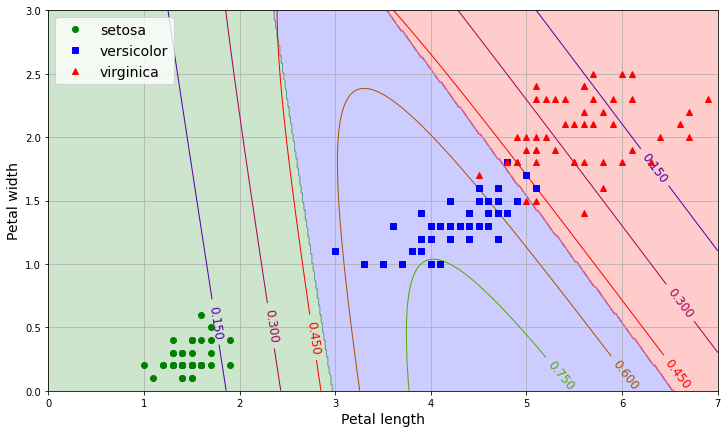

In [45]:
fig = plt.figure(figsize=(12, 7))

custom_cmap = ListedColormap(['g', 'b', 'r'])
plt.contourf(x_pl, x_pw, y_predict.reshape(x_pl.shape), cmap=custom_cmap, alpha=0.2)

for species in target['species'].unique():
    xs = X_full[target['species'] == species][best_features[0]]
    ys = X_full[target['species'] == species][best_features[1]]
    
    plt.plot(xs, ys, ["go", "bs", "r^"][species], label=iris['target_names'][species])

# Contour lines for probability of species == 1 (versicolor)
contour = plt.contour(x_pl, x_pw, y_proba[:, 1].reshape(x_pl.shape), cmap=plt.cm.brg, linewidths=1)

plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.grid()

plt.show()

Contour lines represent certain probabilities of a given flower being Iris Versicolor.